In [1]:
import numpy as np
import random
import tqdm

In [29]:
from os import listdir
 
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# split a document into news story and highlights
def split_story(doc):
    # find first highlight
    index = doc.find('@highlight')
    # split into story and highlights
    story, highlights = doc[:index], doc[index:].split('@highlight')
    # strip extra white space around each highlight
    highlights = [h.strip() for h in highlights if len(h) > 0]
    return story, highlights
 
# load all stories in a directory
def load_stories(directory):
    stories = list()
    for  name in tqdm.tqdm(random.sample(listdir(directory), 4000)):
        filename = directory + '/' + name
        # load document
        doc = load_doc(filename)
        # split into story and highlights
        story, highlights = split_story(doc)
        # store
        stories.append({'story':story, 'highlights':highlights})
    return stories
# load stories
directory = 'C:/Users/anjum/Documents/New folder/cnn/stories/'
stories = load_stories(directory)
# print('Loaded Stories %d' % len(stories))

100%|██████████| 4000/4000 [00:18<00:00, 212.92it/s]


In [30]:
storys=[]
for dicti in stories:
    storys.append(dicti['story'])
    
storys[0], len(storys)

('President Barack Obama and Chinese President Xi Jinping wrapped up their Sunnyland summit Saturday with a late-morning stroll in the California desert.\n\nObama declared the visit "terrific."\n\nOver two days, the two leaders met for a total of eight hours at the Annenberg Retreat at Sunnylands, just outside Palm Springs in California.\n\nThe summit, held just four months after Xi took office, was meant to launch a close new relationship with a new Chinese leader.\n\nThe backdrop was unusual.\n\nOpinion: Obama, talk about political reform with Xi\n\nSunnyland is a private estate of the Annenburg family. It is better known for hosting Frank Sinatra and the Rat Pack, and Ronald Reagan spent New Year\'s Eve 18 times there.\n\nAides say the location offered the two leaders a quiet place to work through a range of issues.\n\nAmong them:\n\nNorth Korea -  The leaders agreed to keep up pressure on the country to rein in its nuclear ambitions.\n\nCyber attacks -  According to the White House

In [31]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anjum\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
doc_complete = storys
doc_clean = [word_tokenize(doc) for doc in doc_complete] 

In [33]:
doc_complete

['President Barack Obama and Chinese President Xi Jinping wrapped up their Sunnyland summit Saturday with a late-morning stroll in the California desert.\n\nObama declared the visit "terrific."\n\nOver two days, the two leaders met for a total of eight hours at the Annenberg Retreat at Sunnylands, just outside Palm Springs in California.\n\nThe summit, held just four months after Xi took office, was meant to launch a close new relationship with a new Chinese leader.\n\nThe backdrop was unusual.\n\nOpinion: Obama, talk about political reform with Xi\n\nSunnyland is a private estate of the Annenburg family. It is better known for hosting Frank Sinatra and the Rat Pack, and Ronald Reagan spent New Year\'s Eve 18 times there.\n\nAides say the location offered the two leaders a quiet place to work through a range of issues.\n\nAmong them:\n\nNorth Korea -  The leaders agreed to keep up pressure on the country to rein in its nuclear ambitions.\n\nCyber attacks -  According to the White House

In [40]:
import gensim
##  Build the bigram and trigram models
bigram = gensim.models.Phrases(doc_clean, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[doc_clean], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
 #trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[doc_clean[0]]]) 

In [41]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [42]:
from gensim.utils import simple_preprocess
import spacy
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [43]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [44]:
# Remove Stop Words
data_words_nostops = remove_stopwords(doc_clean)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1])

In [46]:
# save to file
from pickle import dump
dump(data_lemmatized, open('Assignment_Problem_Cleane_cnn_dataset.pkl', 'wb'))

In [47]:
# Importing Gensim
import gensim
from gensim import corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [48]:
import pickle
pickle.dump(corpus, open("Assignment_problem_Corpus.pkl", "wb"))
id2word.save("Assignment_problem_Dictionary.gensim")

In [49]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [50]:
lda_model.save("Assignment_Problem_model6.gensim")

In [51]:
for i in lda_model.print_topics():
    print(i)

(0, '0.017*"game" + 0.016*"show" + 0.011*"story" + 0.009*"case" + 0.009*"write" + 0.008*"wear" + 0.007*"designer" + 0.007*"video" + 0.006*"film" + 0.006*"photo"')
(1, '0.015*"go" + 0.015*"year" + 0.014*"time" + 0.014*"say" + 0.013*"get" + 0.010*"make" + 0.010*"know" + 0.009*"take" + 0.009*"think" + 0.009*"first"')
(2, '0.030*"say" + 0.013*"government" + 0.011*"would" + 0.008*"country" + 0.007*"state" + 0.007*"charge" + 0.006*"political" + 0.006*"issue" + 0.006*"military" + 0.005*"force"')
(3, '0.020*"use" + 0.015*"case" + 0.014*"company" + 0.011*"system" + 0.009*"technology" + 0.009*"product" + 0.009*"plane" + 0.008*"flight" + 0.007*"engine" + 0.007*"information"')
(4, '0.012*"people" + 0.011*"work" + 0.008*"new" + 0.008*"make" + 0.008*"many" + 0.007*"year" + 0.007*"country" + 0.006*"also" + 0.006*"program" + 0.005*"need"')
(5, '0.088*"say" + 0.014*"report" + 0.013*"people" + 0.011*"accord" + 0.010*"tell" + 0.010*"police" + 0.009*"official" + 0.008*"kill" + 0.008*"find" + 0.006*"area"'

In [52]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.163356267582996

Coherence Score:  0.36814891421074375


In [54]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.175596 -0.097550       1        1  25.912241
2     -0.148449  0.099752       2        1  21.787667
5     -0.144979  0.053163       3        1  20.581415
4     -0.013289 -0.003280       4        1  17.690345
0      0.207072 -0.288674       5        1   8.174039
3      0.275241  0.236589       6        1   5.854293, topic_info=            Term          Freq         Total Category  logprob  loglift
66           say  28160.000000  28160.000000  Default  30.0000  30.0000
289          use   2907.000000   2907.000000  Default  29.0000  29.0000
586   government   3073.000000   3073.000000  Default  28.0000  28.0000
239       report   3843.000000   3843.000000  Default  27.0000  27.0000
169           go   4670.000000   4670.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
244         test    293.164641    600.492524   Topic6  -5.2973   2.1210
283       result    296.220289    873.751977   Topic6  -5.2869   1.7563
2598        site    267.010553    993.986551   Topic6  -5.3907   1.5236
994        cause    260.189452    844.545854   Topic6  -5.4166   1.6606
403          may    274.632775   2692.540945   Topic6  -5.3626   0.5552

[384 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
796       3  0.998719  accident
0         2  0.184808    accord
0         3  0.675005    accord
0         4  0.092404    accord
0         6  0.047565    accord
...     ...       ...       ...
206       5  0.706990     write
83        1  0.554216      year
83        2  0.147502      year
83        3  0.120657      year
83        4  0.177522      year

[613 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 6, 5, 1, 4])

In [57]:
from os import listdir
 
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# split a document into news story and highlights
def split_story(doc):
    # find first highlight
    index = doc.find('@highlight')
    # split into story and highlights
    story, highlights = doc[:index], doc[index:].split('@highlight')
    # strip extra white space around each highlight
    highlights = [h.strip() for h in highlights if len(h) > 0]
    return story, highlights
 
# load all stories in a directory
def load_stories(directory):
    stories = list()
    for  name in tqdm.tqdm(random.sample(listdir(directory), 4000)):
        filename = directory + '/' + name
        # load document
        doc = load_doc(filename)
        # split into story and highlights
        story, highlights = split_story(doc)
        # store
        stories.append({'story':story, 'highlights':highlights})
    return stories
# load stories
directory = 'C:/Users/anjum/Documents/New folder/cnn/stories/'
stories = load_stories(directory)
# print('Loaded Stories %d' % len(stories))

100%|██████████| 4000/4000 [00:19<00:00, 208.15it/s]


In [59]:
import pandas as pd
cnn_df = pd.DataFrame(stories)
cnn_df.head()

story  \
0  (CNN) -- All Katherine McMillan wanted in a sh...   
1  (CNN) -- A defense lawyer in a rape case that ...   
2  (CNN) -- The death toll from Tropical Storm Ag...   
3  (CNN) -- A conference of Islamic prosecutors i...   
4  London (CNN) -- Yesterday brought the sad and ...   

                                          highlights  
0  [Katherine McMillan wanted stylish shoes witho...  
1  [Two 16-year-olds are charged in the alleged r...  
2  [Death toll increases to 152 in Guatemala, Nea...  
3  [Islamic prosecutors draft indictment against ...  
4  [Blackford: Tony Scott was a thrill-seeking ad...

In [60]:
cnn_df.highlights[2]

['Death toll increases to 152 in Guatemala',
 'Nearly 125,000 evacuated and 74,000 in shelters',
 'Guatemala also plagued by volcano',
 'Agatha first named storm of Pacific hurricane season']

In [61]:
cnn_df.story[0]

'(CNN) -- All Katherine McMillan wanted in a shoe was style and comfort without the frilly bows or flowers.\n\nShe\'s a working mother who tends to buy men\'s shirts in small sizes and prefers the kinds of casual shoes made for men -- desert boots, moccasins, chukkas. She\'ll take a pair of shoes or a jacket in olive green or navy blue over lavender or aqua any day.\n\n"I think a lot of my friends would agree that we don\'t want to look like an Easter egg when we go out," said McMillan, who lives in Minneapolis, Minnesota. "I\'m all for feeling like a girly-girl but there are ways to do it without being a French poodle."\n\nDon\'t get her wrong, she likes high heels and dresses, but not in pink. So when she couldn\'t find a pair of shoes she liked, she decided to make her own.\n\nHers are desert boots, moccasins and chukkas made of leather and suede with a kelly green lining to distinguish them from what the guys wear. She launched her made-to-order collection in fall 2011 under the na

In [62]:
def clean_lines(lines):
    cleaned = list()
    # prepare a translation table to remove punctuation
    table = str.maketrans('', '', string.punctuation)
    for line in lines:
        # strip source cnn office if it exists
        index = line.find('(CNN) -- ')
        if index > -1:
            line = line[index+len('(CNN)'):]
        # tokenize on white space
        line = line.split()
        # convert to lower case
        line = [word.lower() for word in line]
        # remove punctuation from each token
        line = [w.translate(table) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        # store as string
        cleaned.append(' '.join(line))
    # remove empty strings
    cleaned = [c for c in cleaned if len(c) > 0]
    return cleaned

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [63]:
dictionary = corpora.Dictionary.load("Assignment_problem_Dictionary.gensim")
model_load = gensim.models.ldamodel.LdaModel.load("Assignment_Problem_model6.gensim")


In [64]:
def sentance_to_topic(df, dictionary, model,):
    Topic_df = pd.DataFrame(columns= ["Sentence", "Topic"])
    for Row_index in range(len(df)):
#         print(Row_index)
        Clean_text = clean_lines(cnn_df.story[Row_index].split("\n"))
#         print("Length of Clean Text: --", len(Clean_text))
        if len(Clean_text) == 0:
            continue
        tokens = remove_stopwords(Clean_text)

        Corpus = [dictionary.doc2bow(token) for token in tokens]
        doc_lda = model[Corpus]

        lda = []
        Topic = []
        for i in doc_lda:
            lda.append(i[0])
        #     print(lda)
        #     print("------------",max(i[0], key = lambda x : x[1] )[0])
            Topic.append(max(i[0], key = lambda x : x[1] )[0])

        df = pd.DataFrame({"Sentence" : Clean_text, "Topic": Topic})
#         print("Length of Df : ----", len(df))
        
        Topic_df = Topic_df.append(df, ignore_index=True,)
        if len(Topic_df) > 100000:
            break
#         print("Length of ,main Df : -------",len(Topic_df))
    return Topic_df

In [65]:
Topic_df = sentance_to_topic(cnn_df, dictionary=dictionary, model=model_load)

In [66]:
Topic_df.to_csv('SentenceTopics.csv') 

In [67]:
len(Topic_df)

85767

In [68]:
Topic_df.head()

Sentence Topic
0  all katherine mcmillan wanted in a shoe was st...     1
1  shes a working mother who tends to buy mens sh...     4
2  i think a lot of my friends would agree that w...     1
3  dont get her wrong she likes high heels and dr...     1
4  hers are desert boots moccasins and chukkas ma...     4

Text(0.5, 1.0, 'Count of instances ')

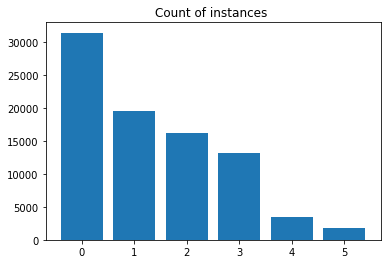

In [69]:
plt.bar([0,1,2,3,4,5], Topic_df.Topic.value_counts(), )
plt.title("Count of instances ")

In [70]:
topics = Topic_df.Topic.tolist()
type(topics)

list

In [71]:
Topic_Name = []
for topic in topics:
    if topic == 0:
        Topic_Name.append("Social")
    elif topic == 1:
        Topic_Name.append("investigate")
    elif topic == 2:
        Topic_Name.append("Artistic")
    elif topic == 3:
        Topic_Name.append("Enterprise")
    elif topic == 4:
        Topic_Name.append("Realistic")
    else : 
        Topic_Name.append("Conventional")

In [72]:
Topic_df["Topic_Name"] = Topic_Name
Topic_df.head()

Sentence Topic   Topic_Name
0  all katherine mcmillan wanted in a shoe was st...     1  investigate
1  shes a working mother who tends to buy mens sh...     4    Realistic
2  i think a lot of my friends would agree that w...     1  investigate
3  dont get her wrong she likes high heels and dr...     1  investigate
4  hers are desert boots moccasins and chukkas ma...     4    Realistic

In [77]:
d = {}
for topic_name in np.unique(Topic_df.Topic_Name):
#     print(topic_name)
    d[topic_name] = Topic_df[Topic_df.Topic_Name == topic_name]["Sentence"].tolist()[:1000]

In [78]:
first_output = pd.DataFrame(d, )

In [79]:
first_output.to_csv("Assignment_Problem_first_output.csv")

In [80]:
import pandas as pd 
import numpy as np
import random
import tqdm

Topic_df = pd.read_csv("SentenceTopics.csv", )
# Topic_df.head(), len(Topic_df)

In [81]:
from itertools import permutations, combinations

In [99]:
Combinations = []
for i in combinations(np.random.random_integers(0,len(Topic_df),500), 3):
    Combinations.append(i)
# len(Combinations), Combinations


In [100]:
Combinations_ = random.sample(Combinations, 500)
# len(Combinations_), Combinations_

In [101]:
Texts = []
Labels = []
count = 0
# Combinations = random.sample(Combinations, 150000)
# Combinations

for i, j, k in tqdm.tqdm(Combinations_):
    if (Topic_df.Topic[i] != Topic_df.Topic[j]) and (Topic_df.Topic[i] != Topic_df.Topic[k]) and (Topic_df.Topic[j] != Topic_df.Topic[k]):
        text = []
        text.append(Topic_df.Sentence.loc[i])
        text.append(Topic_df.Sentence.loc[j])
        text.append(Topic_df.Sentence.loc[k])
        Texts.append(". ".join(text))
        
        label = []
        if Topic_df.Topic.loc[i] == 0 or Topic_df.Topic.loc[j] == 0 or Topic_df.Topic.loc[k] ==0:
            label.append("Social")
        if Topic_df.Topic.loc[i] == 1 or Topic_df.Topic.loc[j] == 1 or Topic_df.Topic.loc[k] ==1:
            label.append("investigate")
        if Topic_df.Topic.loc[i] == 2 or Topic_df.Topic.loc[j] == 2 or Topic_df.Topic.loc[k] ==2:
            label.append("Artistic")
        if Topic_df.Topic.loc[i] == 3 or Topic_df.Topic.loc[j] == 3 or Topic_df.Topic.loc[k] ==3:
            label.append("Enterprise")
        if Topic_df.Topic.loc[i] == 4 or Topic_df.Topic.loc[j] == 4 or Topic_df.Topic.loc[k] ==4:
            label.append("Realistic")
        if Topic_df.Topic.loc[i] == 5 or Topic_df.Topic.loc[j] == 5 or Topic_df.Topic.loc[k] ==5:
            label.append("Conventional")
            
        Labels.append(label)
        if (len(Texts) % 15000) == 0:
            permutated_df = pd.DataFrame({"Texts" :Texts, "Labels":Labels})
            permutated_df.to_csv("Assignment_problem_Second_output.csv")
            print(count+1)
            
permutated_df = pd.DataFrame({"Texts" :Texts, "Labels":Labels})


100%|██████████| 500/500 [00:00<00:00, 6346.14it/s]


In [104]:
permutated_df.to_csv("Assignment_problem_Second_output.csv")

In [102]:
permutated_df.loc[5].Texts,  permutated_df.loc[0].Labels

('during the congressional hearings there was massive evidence that the nixon white house had made policy decisions that were related to campaign contributions the hearings included dramatic stories of one administration official g gordon liddy obtaining a briefcase with and the president reversing policies because the milk industry made donations. it seemed too good to be true andy kaufman still alive. the scandal leaves manhattan district attorney cyrus vance jr again confronted with a sex scandal that bears implications far beyond the courtroom vance was involved in the sexual assault case against former imf chief dominique strausskahn last year a hotel maid accused strausskahn once considered a leading french presidential candidate of assault during an encounter in his room at new yorks sofitel the charges were ultimately dropped',
 ['investigate', 'Artistic', 'Realistic'])

In [108]:
Multi_Label_df = pd.read_csv("C:/Users/anjum/Assignment_problem_Second_output.csv")

In [109]:
Multi_Label_df.head() , len(Multi_Label_df)

(   Unnamed: 0                                              Texts  \
 0           0  long legal battle. that left authorities with ...   
 1           1  impossible to say when hell go but its clear t...   
 2           2  robertson also pointed out that we live in a c...   
 3           3  in an additional nod to her caucuss conservati...   
 4           4  paul giamatti and laura linney won for their r...   
 
                                          Labels  
 0      ['investigate', 'Artistic', 'Realistic']  
 1  ['investigate', 'Realistic', 'Conventional']  
 2         ['Social', 'investigate', 'Artistic']  
 3     ['investigate', 'Artistic', 'Enterprise']  
 4         ['Social', 'investigate', 'Artistic']  ,
 196)

In [110]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import nltk

wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stopwords = set(stopwords.words('english'))

def processing_text(text):
    text = text.replace("\n", " ")
    # split string into words (tokens)
    tokens = nltk.tokenize.word_tokenize(text.lower())
    # keep strings with only alphabets
    tokens = [t for t in tokens if t.isalpha()]
    # put words into base form
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] 
    tokens = [stemmer.stem(t) for t in tokens]
    # remove short words, they're probably not useful
    tokens = [t for t in tokens if len(t) > 2]
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    cleanedText = " ".join(tokens)
    return cleanedText

In [111]:
Multi_Label_df["Processed_text"] = Multi_Label_df["Texts"].apply(processing_text)

In [112]:
tokens = [nltk.tokenize.word_tokenize(text.lower()) for text in Multi_Label_df["Processed_text"].values]

In [113]:
len(tokens), tokens[5]

(196,
 ['dure',
  'congression',
  'hear',
  'massiv',
  'evid',
  'nixon',
  'white',
  'hous',
  'made',
  'polici',
  'decis',
  'relat',
  'campaign',
  'contribut',
  'hear',
  'includ',
  'dramat',
  'stori',
  'one',
  'administr',
  'offici',
  'gordon',
  'liddi',
  'obtain',
  'briefcas',
  'presid',
  'revers',
  'polici',
  'becaus',
  'milk',
  'industri',
  'made',
  'donat',
  'seem',
  'good',
  'true',
  'andi',
  'kaufman',
  'still',
  'aliv',
  'scandal',
  'leaf',
  'manhattan',
  'district',
  'attorney',
  'cyru',
  'vanc',
  'confront',
  'sex',
  'scandal',
  'bear',
  'implic',
  'far',
  'beyond',
  'courtroom',
  'vanc',
  'involv',
  'sexual',
  'assault',
  'case',
  'former',
  'imf',
  'chief',
  'dominiqu',
  'strausskahn',
  'last',
  'year',
  'hotel',
  'maid',
  'accus',
  'strausskahn',
  'onc',
  'consid',
  'lead',
  'french',
  'presidenti',
  'candid',
  'assault',
  'dure',
  'encount',
  'room',
  'new',
  'york',
  'sofitel',
  'charg',
  'u

In [114]:
from gensim.models import Word2Vec

# train model
model = Word2Vec(tokens, min_count=2)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(len(words))
# save model
model.save('Assignment_Problem_Word2Vec_model.bin')

Word2Vec(vocab=1961, size=100, alpha=0.025)
1961


# Plot Word Vectors Using PCA


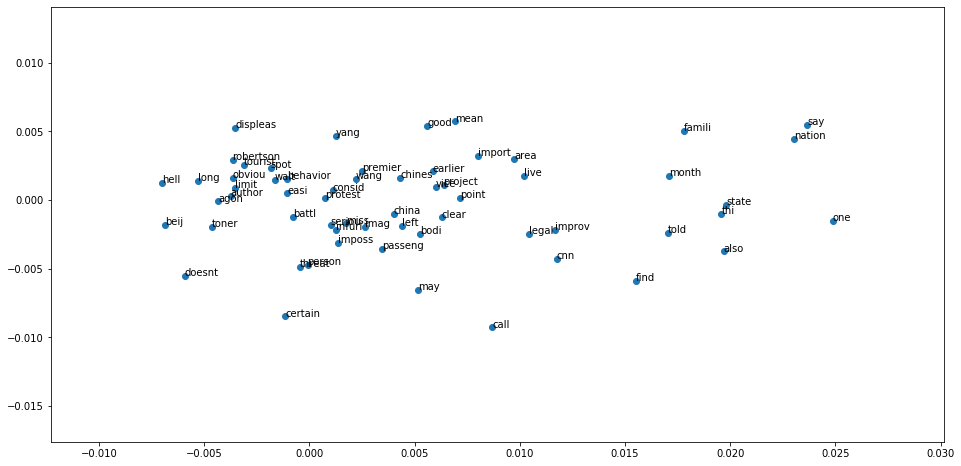

In [115]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
pyplot.figure(figsize=(16,8))

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection of first 60 
pyplot.scatter(result[:60, 0], result[:60, 1], )
words = list(model.wv.vocab)[:60]
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [116]:
def replace_string(text):
    return text.replace('[' ,"").replace(']',"").replace("'", "").split(", ")

In [117]:
Multi_Label_df["Label_list"] = Multi_Label_df["Labels"].apply(replace_string)

In [118]:
Multi_Label_df.head()

Unnamed: 0                                              Texts  \
0           0  long legal battle. that left authorities with ...   
1           1  impossible to say when hell go but its clear t...   
2           2  robertson also pointed out that we live in a c...   
3           3  in an additional nod to her caucuss conservati...   
4           4  paul giamatti and laura linney won for their r...   

                                         Labels  \
0      ['investigate', 'Artistic', 'Realistic']   
1  ['investigate', 'Realistic', 'Conventional']   
2         ['Social', 'investigate', 'Artistic']   
3     ['investigate', 'Artistic', 'Enterprise']   
4         ['Social', 'investigate', 'Artistic']   

                                      Processed_text  \
0  long legal battl left author one person find l...   
1  imposs say hell clear toner told cnn famili mi...   
2  robertson also point live cultur recordbreak f...   
3  addit nod caucu conserv pelosi hous major whip...   
4  paul giamatti laura linney role hbo john adam ...   

                               Label_list  
0      [investigate, Artistic, Realistic]  
1  [investigate, Realistic, Conventional]  
2         [Social, investigate, Artistic]  
3     [investigate, Artistic, Enterprise]  
4         [Social, investigate, Artistic]

In [119]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
Labels_one_hot = pd.DataFrame(mlb.fit_transform((Multi_Label_df.Label_list.values)),
                   columns=mlb.classes_)

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [121]:
X_train, X_test, y_train, y_test = train_test_split(Multi_Label_df.Processed_text.values, Labels_one_hot.values, test_size=0.33, random_state=42)

In [122]:
X_train.shape, y_train.shape

((131,), (131, 6))

In [123]:
X_test.shape, y_test.shape

((65,), (65, 6))

In [124]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')

trained_vectorizer = vectorizer.fit_transform(X_train)

In [125]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

bagClassifier = OneVsRestClassifier(BaggingClassifier(n_jobs=-1))
bagClassifier.fit(trained_vectorizer, y_train)

OneVsRestClassifier(estimator=BaggingClassifier(n_jobs=-1))

In [128]:
import pickle
pickle.dump(bagClassifier, open("C:/Users/anjum/Assignment_problem_bagClassifier.pkl", "wb"), )

In [140]:
#bagClassifier.predict_proba(vectorizer.transform(X_test[0]))

In [134]:
random_sentences = Topic_df.sample(100)["Sentence"].values
type(random_sentences)

numpy.ndarray

In [135]:
def predict_proba(texts):
    df = {"Data": [], Labels_one_hot.columns[0] : [], Labels_one_hot.columns[1] : [],
         Labels_one_hot.columns[2] : [], Labels_one_hot.columns[3] : [], Labels_one_hot.columns[4] : [],
         Labels_one_hot.columns[5] : []}
    for text_ in texts:
        
        df["Data"].append(text_)
        processed_text = processing_text(text_)
        proba = bagClassifier.predict_proba(vectorizer.transform([processed_text]))
        df[Labels_one_hot.columns[0]].append(proba[0][0])
        df[Labels_one_hot.columns[1]].append(proba[0][1])
        df[Labels_one_hot.columns[2]].append(proba[0][2])
        df[Labels_one_hot.columns[3]].append(proba[0][3])
        df[Labels_one_hot.columns[4]].append(proba[0][4])
        df[Labels_one_hot.columns[5]].append(proba[0][5])
#         print(df)
    return pd.DataFrame(df)

In [137]:
final_df = predict_proba(random_sentences)
final_df.head()

Data  Artistic  Conventional  \
0  on the videosharing site for tweens called kid...       1.0           0.9   
1  if the law is changed successfully implementin...       1.0           0.9   
2  when the letter that you are concentrating on ...       1.0           1.0   
3  this is a great time to apply for a great job ...       1.0           0.9   
4  oktoberfest organizer michael sanders said he ...       0.3           1.0   

   Enterprise  Realistic  Social  investigate  
0         0.0        0.4     0.0          1.0  
1         0.0        0.7     0.1          0.8  
2         0.2        0.4     0.0          1.0  
3         0.0        0.3     0.0          1.0  
4         0.0        0.4     0.0          1.0

In [ ]:
final_df.to_csv("Assignment_Problem_final_output.csv")

In [139]:
#predict_proba[]